# Lab 07: Time Series Feature Extraction and Clustering

This notebook provides an introduction to extracting features from time series data
and applying clustering algorithms. We will explore different feature extraction
techniques and compare the results of standard k-means clustering with bisecting k-means.

## Section 1: Time Series Feature Extraction

In this section, we will explore different methods for extracting meaningful features
from time series data. These features can then be used as input for various
machine learning tasks, such as clustering, classification, or regression. We will
focus on Electrocardiogram (EKG) or EKG-like time series data.

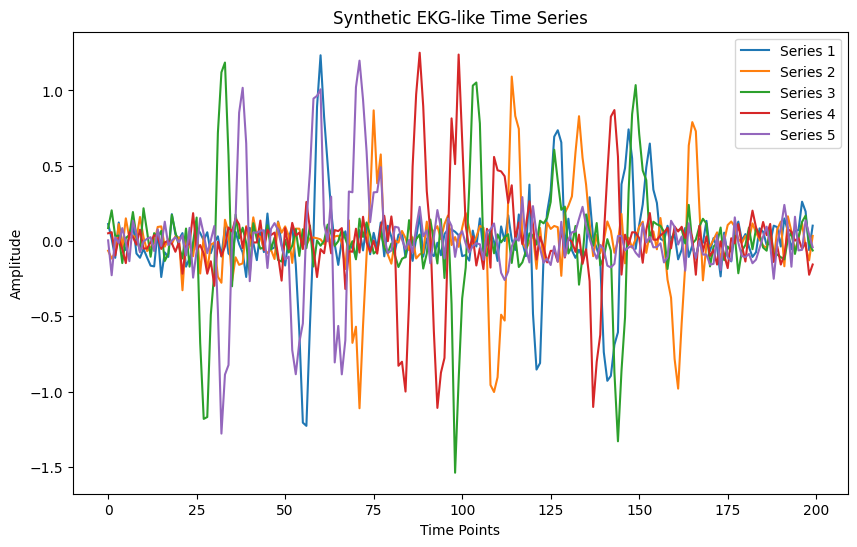

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

# set random seed for reproducibility
random_state = 67
np.random.seed(random_state)

# Generate synthetic EKG-like data
n_series = 150
length = 200
ekg_data = []
for _ in range(n_series):
    base_line = np.random.randn(length) * 0.1
    qrs_complex = np.zeros(length)
    peak_indices = np.sort(np.random.choice(np.arange(20, length - 20), size=3, replace=False))
    for peak in peak_indices:
        qrs_complex[peak-5:peak+6] += np.sin(np.linspace(-np.pi, np.pi, 11)) + np.random.randn(11) * 0.2
    t_wave = np.zeros(length)
    t_peak = peak_indices[1] + np.random.randint(10, 30)
    if 0 <= t_peak < length:
        t_wave[t_peak-3:t_peak+4] += 0.5 * np.exp(-np.linspace(-1, 1, 7)**2) + np.random.randn(7) * 0.1
    ekg_series = base_line + qrs_complex + t_wave
    ekg_data.append(ekg_series)

ekg_df = pd.DataFrame(ekg_data).T
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(ekg_df[i], label=f'Series {i+1}')
plt.title('Synthetic EKG-like Time Series')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Example 1: Statistical and Peak-Based Features

In this example, we will extract a set of descriptive statistical features along with
the number of prominent peaks present in each time series.

**Task:** For each of the generated EKG-like time series, calculate the following features:

* Mean
* Standard Deviation
* Skewness
* Kurtosis
* Number of Peaks (you can use `scipy.signal.find_peaks`)

Store these features in a Pandas DataFrame where each row represents a time series
and each column represents a feature.

In [30]:
# Feature Extraction - Example 1
features_ex1 = []
for i in range(n_series):
    series = ekg_df[i].values
    mean_val = np.mean(series)
    std_val = np.std(series)
    skew_val = skew(series)
    kurt_val = kurtosis(series)
    peaks, _ = find_peaks(series, prominence=0.5) # Adjust prominence as needed
    n_peaks = len(peaks)
    features_ex1.append([mean_val, std_val, skew_val, kurt_val, n_peaks])

features_df_ex1 = pd.DataFrame(features_ex1, columns=['mean', 'std', 'skewness', 'kurtosis', 'n_peaks'])
print("Features (Example 1):\n", features_df_ex1)

Features (Example 1):
          mean       std  skewness  kurtosis  n_peaks
0    0.000176  0.292057 -0.430560  5.689415        5
1    0.002328  0.286658 -0.295270  4.789525        4
2    0.005266  0.333830 -0.460550  6.551689        4
3    0.009330  0.310083  0.169164  5.155564        5
4    0.004379  0.310405  0.323320  5.077231        4
..        ...       ...       ...       ...      ...
145 -0.003038  0.310399 -0.716550  6.216885        4
146  0.006544  0.301172 -0.414093  6.294980        4
147  0.006972  0.314723  0.097725  6.441009        4
148  0.017178  0.322320  0.505769  7.655419        3
149  0.013741  0.251342 -0.047823  7.558861        5

[150 rows x 5 columns]


### Example 2: Equal Width Partitioning with Mean and Standard Deviation

This method involves dividing each time series into a fixed number of equal-width
buckets and then calculating statistical measures within each bucket. This ensures
that all time series are represented by the same number of features, regardless
of their length or the distribution of their values.

**Task:**

1.  Define a function that takes a time series and the number of buckets (`n_buckets`) as input.
2.  Inside the function, divide the time series into `n_buckets` of equal width.
3.  For each bucket, calculate the mean and the standard deviation of the values within that bucket.
4.  The function should return a flattened array of these mean and standard deviation values. For example, if `n_buckets` is 5, the output should be an array of 10 features (mean\_bucket1, std\_bucket1, mean\_bucket2, std\_bucket2, ..., mean\_bucket5, std\_bucket5).
5.  Apply this function to each of the generated EKG-like time series using, say, `n_buckets = 5`.
6.  Store the resulting features in a Pandas DataFrame.

In [31]:
# Feature Extraction - Example 2
def equal_width_partitioning(series, n_buckets):
    min_val = np.min(series)
    max_val = np.max(series)
    bucket_width = (max_val - min_val) / n_buckets
    features = []
    for i in range(n_buckets):
        start = min_val + i * bucket_width
        end = min_val + (i + 1) * bucket_width
        bucket_values = series[(series >= start) & (series < end)]
        if len(bucket_values) > 0:
            features.append(np.mean(bucket_values))
            features.append(np.std(bucket_values))
        else:
            features.append(0) # Handle empty buckets
            features.append(0)
    return np.array(features)

n_buckets = 5
features_ex2 = []
for i in range(n_series):
    series = ekg_df[i].values
    features_ex2.append(equal_width_partitioning(series, n_buckets))

features_df_ex2 = pd.DataFrame(features_ex2, columns=[f'mean_bucket_{i//2 + 1}' if i % 2 == 0 else f'std_bucket_{(i-1)//2 + 1}' for i in range(n_buckets * 2)])
print("\nFeatures (Example 2):\n", features_df_ex2)


Features (Example 2):
      mean_bucket_1  std_bucket_1  mean_bucket_2  std_bucket_2  mean_bucket_3  \
0        -0.950991      0.177168      -0.588037      0.066811      -0.006208   
1        -0.915843      0.134385      -0.378641      0.131958       0.009301   
2        -1.304249      0.149193      -0.721539      0.175679      -0.043877   
3        -0.911311      0.129061      -0.290767      0.132968       0.010380   
4        -0.927288      0.160278      -0.604508      0.089167      -0.017365   
..             ...           ...            ...           ...            ...   
145      -1.284493      0.233608      -0.811342      0.149060      -0.069007   
146      -1.073788      0.109277      -0.341647      0.123506       0.013322   
147      -0.881067      0.190438      -0.152931      0.101479       0.060121   
148      -0.942877      0.180207      -0.219926      0.112470       0.034002   
149      -1.102174      0.153274      -0.565538      0.159859      -0.011980   

     std_bucket

## Section 2: Time Series Clustering

In this section, we will apply clustering algorithms to the extracted features to
group similar time series together. We will first demonstrate k-means clustering
and then explore the bisecting k-means algorithm.

### 2.1 K-Means Clustering

K-means is a popular iterative clustering algorithm that aims to partition $n$
observations into $k$ clusters in which each observation belongs to the cluster
with the nearest mean (cluster centers or cluster centroid), serving as a prototype
of the cluster.

**Task:**

1.  Choose one of the feature sets you created in Section 1 (either `features_df_ex1` or `features_df_ex2`).
2.  It's often beneficial to scale the features before applying k-means. Use `StandardScaler` from `sklearn.preprocessing` to standardize the chosen feature set.
3.  Apply the `KMeans` algorithm from `sklearn.cluster` with `n_clusters=5` to the scaled features.
4.  Obtain the cluster labels assigned to each time series.
5.  Visualize the clustering results. You can do this by plotting the original time series, with each series colored according to its assigned cluster.

K-Means Cluster Labels:
 [2 4 4 2 4 1 2 0 4 2 0 4 0 4 4 4 0 3 0 4 4 0 3 4 2 4 4 0 3 2 3 4 0 2 4 2 0
 0 0 2 2 2 3 2 1 1 0 4 2 0 4 0 4 0 3 3 4 2 3 2 0 4 2 4 2 2 3 4 3 2 4 2 4 2
 4 0 0 3 4 2 3 0 1 3 4 0 4 2 0 3 2 4 2 3 0 0 3 3 2 3 2 0 1 2 2 4 4 4 4 3 3
 0 2 0 1 3 2 3 3 3 3 3 0 2 3 4 0 3 1 3 3 1 3 4 3 1 4 4 4 4 4 3 0 4 3 4 4 4
 3 0]


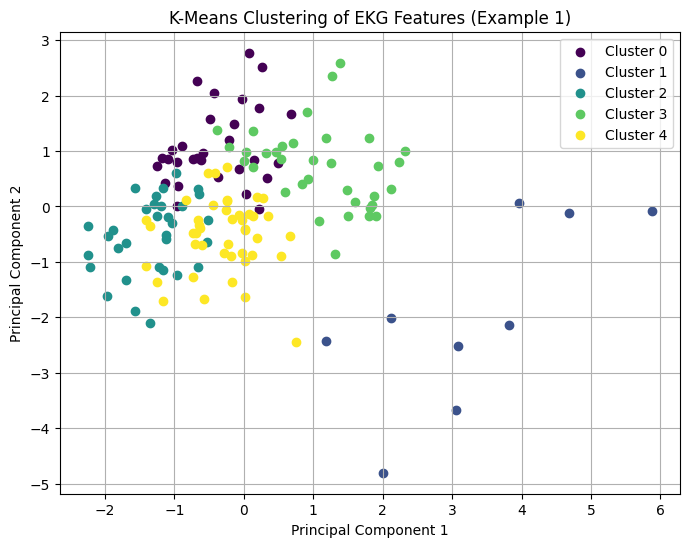


K-Means Cluster Labels (using Example 2 features):
 [1 1 0 1 1 3 0 4 0 2 1 0 1 1 1 0 4 4 1 0 1 1 1 1 0 1 1 4 1 0 1 1 0 1 0 1 1
 1 1 4 4 1 4 0 2 2 1 0 0 0 1 1 1 1 4 1 1 0 1 0 4 2 1 1 0 1 4 1 1 2 0 0 1 0
 1 1 4 1 0 2 4 1 2 4 1 4 0 1 1 4 1 1 0 1 0 1 4 1 0 1 4 1 2 1 1 1 1 0 0 4 1
 1 0 1 3 4 0 4 4 4 4 4 1 0 1 1 0 1 3 1 4 3 4 0 4 3 1 1 1 1 1 4 0 1 4 0 1 4
 4 0]


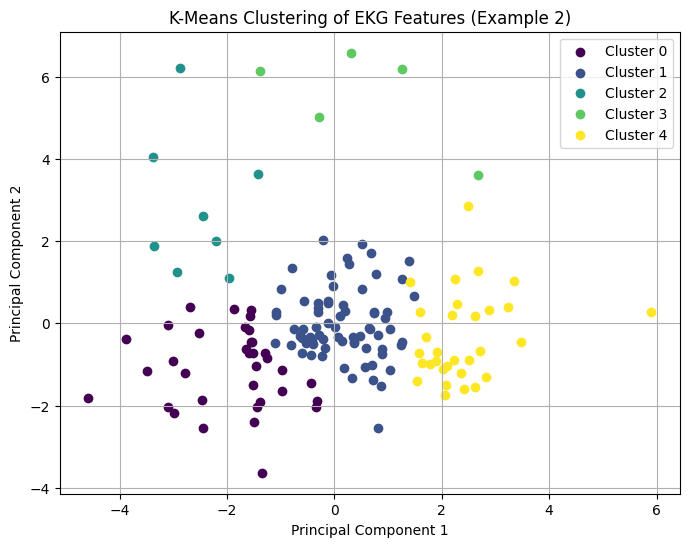

In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

# Using features from Example 1
X = features_df_ex1.values
scaler = StandardScaler()
X_scaled_ex1 = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=random_state, n_init=10)
cluster_labels_kmeans = kmeans.fit_predict(X_scaled_ex1)

print("K-Means Cluster Labels:\n", cluster_labels_kmeans)

# Visualization
def visualize_clustering_2d(X, labels, title):
    """
    Performs 2D dimensionality reduction using PCA and visualizes the clustering.

    Args:
        X (np.array): The data to cluster.
        labels (np.array): Cluster labels for each data point.
        title (str): The title of the plot.
    """
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)

    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('viridis', len(unique_labels))
    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0]
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Cluster {label}', color=cmap(i))
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize clustering results in 2D
visualize_clustering_2d(X_scaled_ex1, cluster_labels_kmeans, 'K-Means Clustering of EKG Features (Example 1)')

# Repeat for features from Example 2 (optional, for comparison)
X_ex2 = features_df_ex2.values
X_scaled_ex2 = scaler.fit_transform(X_ex2)

kmeans_ex2 = KMeans(n_clusters=5, random_state=random_state, n_init=10)
cluster_labels_kmeans_ex2 = kmeans_ex2.fit_predict(X_scaled_ex2)

print("\nK-Means Cluster Labels (using Example 2 features):\n", cluster_labels_kmeans_ex2)

# Visualization for Example 2
pca = PCA(n_components=2)
X_reduced_ex2 = pca.fit_transform(X_scaled_ex2)
visualize_clustering_2d(X_reduced_ex2, cluster_labels_kmeans_ex2, 'K-Means Clustering of EKG Features (Example 2)')

### 2.2 Bisecting K-Means Clustering

Bisecting k-means is a divisive hierarchical clustering algorithm. It starts with
all data points in one cluster and iteratively splits clusters into two sub-clusters
until the desired number of clusters is reached. The splitting process typically
involves using the standard k-means algorithm (with $k=2$) to find the best way
to divide a chosen cluster.

The algorithm generally proceeds as follows:

1.  Initialize by placing all data points into a single cluster.
2.  While the number of clusters is less than the desired number ($k$):
    a. Select a cluster to split (various strategies exist for this, such as choosing the largest cluster or the cluster with the highest Sum of Squared Errors (SSE)).
    b. Apply the standard k-means algorithm with $k=2$ to the selected cluster to find the best two sub-clusters.
    c. Replace the original cluster with these two new sub-clusters.

**Task:**

Implement the bisecting k-means algorithm. You can use the `KMeans` implementation from `sklearn.cluster` (with `n_clusters=2`) as the kernel for splitting the clusters.

Your implementation should:

1.  Take the scaled feature set (from either Example 1 or Example 2) and the desired number of clusters ($k=5$) as input.
2.  Initialize a list of clusters, starting with all data points in one cluster. You can represent a cluster by the indices of the data points belonging to it.
3.  Iteratively perform the splitting process until $k$ clusters are formed. For each split, you will need to:
    * Choose a cluster to split. A simple strategy is to choose the cluster with the largest number of data points.
    * Apply k-means ($k=2$) to the data points within the chosen cluster.
    * Update the list of clusters by replacing the split cluster with the two resulting sub-clusters.
4.  After the algorithm finishes, return the cluster assignments for each data point.

Finally, visualize the clustering results obtained from your bisecting k-means implementation (for $k=10$) by plotting the original time series, colored according to their assigned clusters. I've provided a function that can align the colors of the two clusterings based on the Euclidean distance of the cluster centroids. Compare these results with the clustering obtained from the standard k-means algorithm.


Bisecting K-Means Cluster Labels (using Example 2 features):
 [3 2 3 2 3 0 3 2 3 3 3 3 2 3 3 3 1 1 2 3 3 2 2 3 3 2 3 1 2 3 2 3 3 2 3 3 2
 2 2 1 1 2 1 3 4 3 2 3 3 3 2 2 2 3 0 2 2 3 2 3 1 3 2 3 3 3 1 2 2 3 3 3 2 3
 2 2 1 2 3 3 1 3 4 1 3 2 3 3 3 1 3 3 3 2 3 2 1 2 3 2 1 2 4 2 3 2 3 3 3 1 2
 2 3 3 0 1 3 1 1 1 1 1 3 3 3 2 3 2 0 2 1 0 2 3 1 4 3 2 2 2 2 2 3 2 1 3 2 1
 1 3]


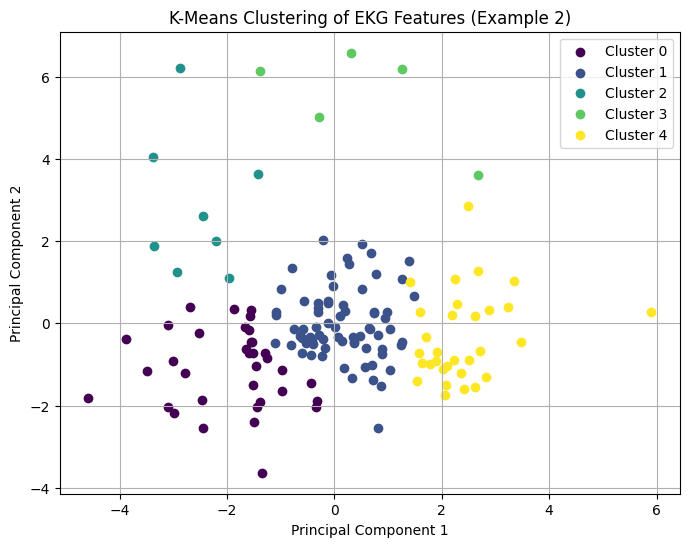

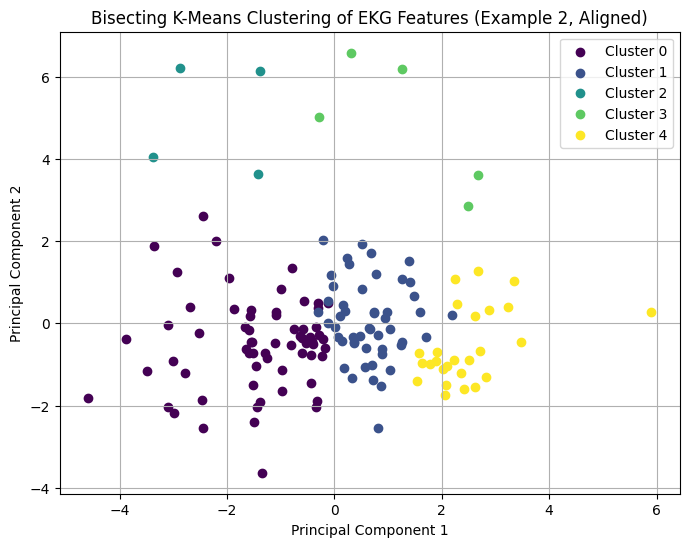

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def sse(data, labels, centers):
    """
    Computes the sum of squared errors (SSE) for the given data and cluster labels.

    Args:
        data (np.array): The data to compute SSE for.
        labels (np.array): Cluster labels for each data point.
        centers (np.array): Cluster centers.
    """
    return sum(np.min(pairwise_distances_argmin_min(data, centers)[1])**2 for i in range(len(data)))


def bisecting_kmeans(X, k, random_state=167, n_init=10):
    """
    Implements the bisecting k-means algorithm.

    Args:
        X (np.array): The data to cluster.
        k (int): The desired number of clusters.
        random_state (int): Random seed for reproducibility.
        n_init (int): Number of times k-means will be run with different centroid seeds.

    Returns:
        np.array: Cluster labels for each data point.
    """
    # Start with one cluster containing all data points
    clusters = [X]
    # cluster_indices = [np.arange(len(X))]
    
    while len(clusters) < k:
        # Find cluster with max SSE or size or variance
        # Here, we use SSE as the criterion

        sses_and_clusters = []
        for cluster in clusters:
            center = np.mean(cluster, axis=0, keepdims=True)
            sses_and_clusters.append(sse(cluster, None, center))

        # extract the chosen cluster
        i = np.argmax(sses_and_clusters)
        cluster_to_split = clusters.pop(i)
        
        # Perform k-means on the chosen cluster with k=2 in order to split it into two subclusters
        kmeans_split = KMeans(n_clusters=2, random_state=random_state, n_init=n_init)
        split_labels = kmeans_split.fit_predict(cluster_to_split)
        
        # Extend the clusters list with the two new clusters
        cluster1 = cluster_to_split[split_labels == 0]
        cluster2 = cluster_to_split[split_labels == 1]

        clusters.extend([cluster1, cluster2])
        
    # Assign final labels to each sample in the original data
    final_labels = np.zeros(len(X), dtype=int)
    for i, cluster in enumerate(clusters):
        for row in cluster:
            index = np.where((X == row).all(axis=1))[0][0]
            final_labels[index] = i
    return final_labels


# Apply bisecting k-means to the scaled features from Example 2
cluster_labels_bisecting_kmeans_ex2 = bisecting_kmeans(X_scaled_ex2, k=5, random_state=random_state)
print("\nBisecting K-Means Cluster Labels (using Example 2 features):\n", cluster_labels_bisecting_kmeans_ex2)

# Visualization of Bisecting K-Means results aligned with K-Means labels
def align_cluster_labels(X, labels1, labels2):
    """
    Aligns the cluster labels of two clusterings based on centroid similarity using 2D PCA representation of the data.

    Args:
        X (np.array): The data that were clustered, or a 2D representation of those samples.
        labels1 (np.array): Cluster labels for the first clustering.
        labels2 (np.array): Cluster labels for the second clustering.

    Returns:
        np.array: Re-labeled version of labels2, aligned with labels1.
    """
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    # Compute centroids for both label sets
    centroids1 = np.array([X[labels1 == label].mean(axis=0) for label in np.unique(labels1)])
    centroids2 = np.array([X[labels2 == label].mean(axis=0) for label in np.unique(labels2)])
    
    # Create a cost matrix for the assignment problem.
    # The cost is the Euclidean distance between centroids.
    # This is a square matrix of size n_clusters1 x n_clusters2
    # where n_clusters1 and n_clusters2 are the number of unique labels 
    # in labels1 and labels2, respectively.
    n_clusters1 = len(np.unique(labels1))
    n_clusters2 = len(np.unique(labels2))

    if n_clusters1 != n_clusters2:
        raise ValueError("Number of clusters in both label sets must be the same for alignment.")

    cost_matrix = np.zeros((n_clusters1, n_clusters2))
    unique_labels1 = np.unique(labels1)
    unique_labels2 = np.unique(labels2)

    label_to_index1 = {label: i for i, label in enumerate(unique_labels1)}
    label_to_index2 = {label: i for i, label in enumerate(unique_labels2)}

    for label1 in unique_labels1:
        for label2 in unique_labels2:
            index1 = label_to_index1[label1]
            index2 = label_to_index2[label2]
            cost_matrix[index1, index2] = np.linalg.norm(centroids1[index1] - centroids2[index2])

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    label_mapping = {unique_labels2[col]: unique_labels1[row] for col, row in zip(col_ind, row_ind)}
    aligned_labels2 = np.array([label_mapping[label] for label in labels2])
    return aligned_labels2

# Align the cluster labels of bisecting k-means with k-means
aligned_labels = align_cluster_labels(X_reduced_ex2, cluster_labels_kmeans_ex2, cluster_labels_bisecting_kmeans_ex2)
visualize_clustering_2d(X_reduced_ex2, cluster_labels_kmeans_ex2, 'K-Means Clustering of EKG Features (Example 2)')
visualize_clustering_2d(X_reduced_ex2, aligned_labels, 'Bisecting K-Means Clustering of EKG Features (Example 2, Aligned)')

**Observations**

Both the standard k-means and the bisection k-means have very similar clustering. The only major difference is that cluster 0 seems to be somewhat larger (it now contains points that used to be in clusters 1 and 2), while custer lost a few points but gained soem points from cluster 4. Cluster 4 also lost a point to cluster 3, while cluster 2 took a point from cluster 3. Overall though the clustering in the bisection version seems to be a bit cleaner than in the standard k-means, as most of the clusters seem to form more coherent groups with points that are closer to each other, wheras the standard k-means clusters are the slightest bit less neat. However, the number of points in each cluster in the bisection version tend to be more unevenly distributed, with most points being in clusters 0 or 1, a few less points in cluster 4, and the least points in clusters 2 and 3. In comparison, the standard k-means was a little more evenly distributed and had mroe points in clusters 2 and 4, although the same general pattern was still present with high numbers of points being in clusters 0, 1, and 4.

### **Exercise:**

Experiment with different values for the `prominence` parameter in the `find_peaks` function in Example 1, the number of buckets in Example 2, or the way you choose the next cluster to bisect in the bisection k-means implementation. How does it affect the number of peaks detected and the result?

## **Experiment 1: Prominence**

In [34]:
prominences = [0.01, 0.25, 0.5, 0.75, 1, 2, 5, 10, 15, 20]

for prominenceVal in prominences:
    features_ex1_experiment = []
    for i in range(n_series):
        series = ekg_df[i].values
        mean_val = np.mean(series)
        std_val = np.std(series)
        skew_val = skew(series)
        kurt_val = kurtosis(series)
        peaks, _ = find_peaks(series, prominence=prominenceVal) # Adjust prominence as needed
        n_peaks = len(peaks)
        features_ex1_experiment.append([mean_val, std_val, skew_val, kurt_val, n_peaks])
    
    features_df_ex1_experiment = pd.DataFrame(features_ex1_experiment, columns=['mean', 'std', 'skewness', 'kurtosis', 'n_peaks'])
    print("Prominence: %.2f\nFeatures (Example 1):\n%s" % (prominenceVal, features_df_ex1_experiment))

Prominence: 0.01
Features (Example 1):
         mean       std  skewness  kurtosis  n_peaks
0    0.000176  0.292057 -0.430560  5.689415       58
1    0.002328  0.286658 -0.295270  4.789525       59
2    0.005266  0.333830 -0.460550  6.551689       57
3    0.009330  0.310083  0.169164  5.155564       66
4    0.004379  0.310405  0.323320  5.077231       54
..        ...       ...       ...       ...      ...
145 -0.003038  0.310399 -0.716550  6.216885       53
146  0.006544  0.301172 -0.414093  6.294980       58
147  0.006972  0.314723  0.097725  6.441009       61
148  0.017178  0.322320  0.505769  7.655419       65
149  0.013741  0.251342 -0.047823  7.558861       58

[150 rows x 5 columns]
Prominence: 0.25
Features (Example 1):
         mean       std  skewness  kurtosis  n_peaks
0    0.000176  0.292057 -0.430560  5.689415       16
1    0.002328  0.286658 -0.295270  4.789525       16
2    0.005266  0.333830 -0.460550  6.551689       18
3    0.009330  0.310083  0.169164  5.155564       

**Observations**

The prominence value has a large impact on the number of peaks in the data. Generally, very low prominence values give a very high number of peaks for all the data points (with a prominence value of 0.01 giving peak values close to 60 and a prominence value of 0.25 giving peak values roughly between 15 and 20) while very high prominence values give a very low number of peaks for the data points (prominence values drop down from 4-5 at prominence 0.5 to 2-4 at prominence 1.0, then the drop down to 1-2 at prominence 2.0 and for prominence 5.0 and higher it gives 0 peaks). The mean, standard deviation, skwerness, and kurtosis are all not affected at all by the prominence value. 

# **Experiment 2: Bucket Sizes**

In [35]:
bucket_nums = [1, 2, 3, 5, 7, 10, 15, 20, 50, 75, 100, 150]

for n_buckets in bucket_nums:
    features_ex2_experiment = []
    for i in range(n_series):
        series = ekg_df[i].values
        features_ex2_experiment.append(equal_width_partitioning(series, n_buckets))
    
    features_df_ex2_experiment = pd.DataFrame(features_ex2_experiment, columns=[f'mean_bucket_{i//2 + 1}' if i % 2 == 0 else f'std_bucket_{(i-1)//2 + 1}' for i in range(n_buckets * 2)])
    print(f"\nn_buckets: {n_buckets}") 
    print("\nFeatures (Example 2):\n", features_df_ex2_experiment)


n_buckets: 1

Features (Example 2):
      mean_bucket_1  std_bucket_1
0         0.000176      0.292057
1        -0.003147      0.276751
2        -0.000662      0.323995
3         0.003094      0.298091
4        -0.001617      0.299410
..             ...           ...
145      -0.008277      0.302227
146      -0.000401      0.285505
147      -0.000799      0.295754
148       0.009011      0.301783
149       0.008197      0.239468

[150 rows x 2 columns]

n_buckets: 2

Features (Example 2):
      mean_bucket_1  std_bucket_1  mean_bucket_2  std_bucket_2
0        -0.162995      0.247670       0.176946      0.226184
1        -0.191509      0.253435       0.140208      0.196077
2        -0.609809      0.419947       0.067399      0.225622
3        -0.108185      0.227619       0.273618      0.275021
4        -0.218238      0.252833       0.138023      0.237654
..             ...           ...            ...           ...
145      -0.842412      0.285646       0.050023      0.199984
146     

**Observations**

When using a bucket size of 1, the means for each of the data points are close to 0, although the standard deviation is relatively high at around 0.3 per bucket. This makes sense, as the EKG graph at the top of the file indicates that the EKG values are all somewhat close to 0 since the values are very small, and in a bucket size of 1 the means for each data point would essentially have the same mean as the mean of the dataset without bucketing. Also, having just one bucket for all the data means that dissimilar data points will be grouped together, which explains why the variance is so high. When the bucket size slightly increases the means quickly become much more variable acrosss the different buckets (between roughly -1 and 1) due to more similar data points being grouped together, although variances still remain somewhat high between 0.2 and 0.3, indicating that the number of buckets is still too large and the points within them are too dissimilar. However, standard deviation does gradually decrease even after using just 2 buckets, although it becomes very low when 15 or more buckets are used and is virually 0 when 50 or more buckets are used. Note that the means of each bucket highly depend on the bucket they happen to fall into, and the standard deviation varies greatly as well (until when using 50 or more buckets, at which point almost all standard deviations are 0).

# **Experiment 3: Bisecting Methods**


Bisecting K-Means Cluster Labels (using Example 2 features):
 [3 2 3 2 3 0 3 2 3 3 3 3 2 3 3 3 1 1 2 3 3 2 2 3 3 2 3 1 2 3 2 3 3 2 3 3 2
 2 2 1 1 2 1 3 4 3 2 3 3 3 2 2 2 3 0 2 2 3 2 3 1 3 2 3 3 3 1 2 2 3 3 3 2 3
 2 2 1 2 3 3 1 3 4 1 3 2 3 3 3 1 3 3 3 2 3 2 1 2 3 2 1 2 4 2 3 2 3 3 3 1 2
 2 3 3 0 1 3 1 1 1 1 1 3 3 3 2 3 2 0 2 1 0 2 3 1 4 3 2 2 2 2 2 3 2 1 3 2 1
 1 3]


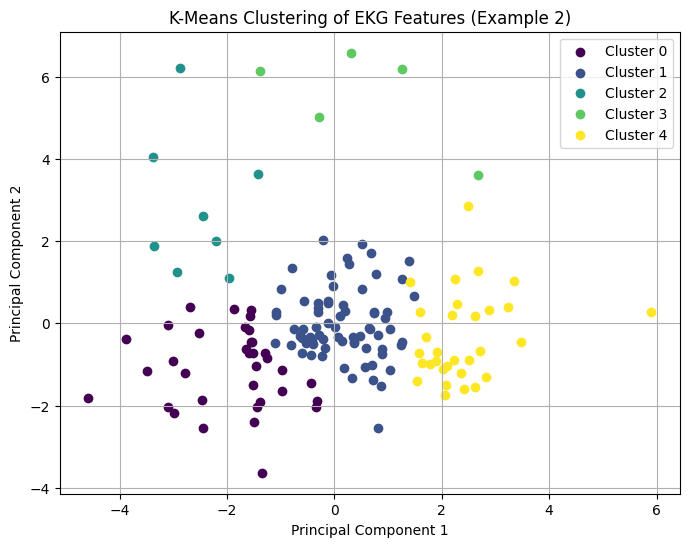

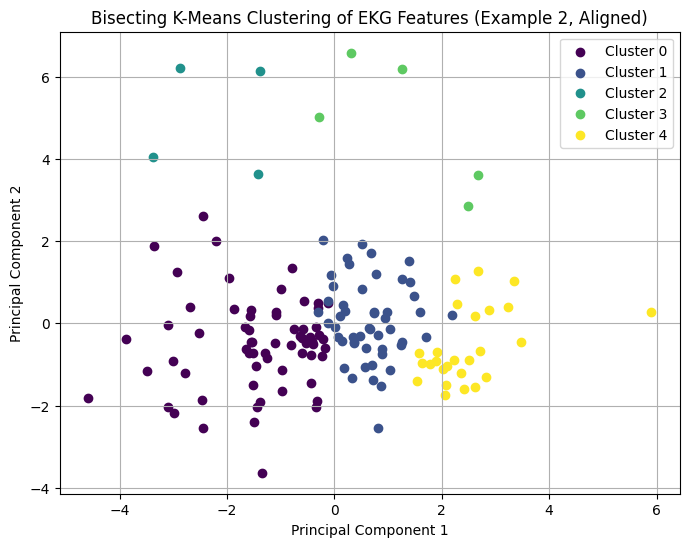

In [36]:
def max_size_bisecting_kmeans(X, k, random_state=167, n_init=10):
    """
    Implements the bisecting k-means algorithm.

    Args:
        X (np.array): The data to cluster.
        k (int): The desired number of clusters.
        random_state (int): Random seed for reproducibility.
        n_init (int): Number of times k-means will be run with different centroid seeds.

    Returns:
        np.array: Cluster labels for each data point.
    """
    # Start with one cluster containing all data points
    clusters = [X]
    
    while len(clusters) < k:
        # Find cluster with max SSE or size or variance
        # Here, we use max size as the criterion

        # extract the chosen cluster
        index_to_split = np.argmax([len(cluster) for cluster in clusters])
        cluster_to_split = clusters.pop(index_to_split)
        
        # Perform k-means on the chosen cluster with k=2 in order to split it into two subclusters
        kmeans_split = KMeans(n_clusters=2, random_state=random_state, n_init=n_init)
        split_labels = kmeans_split.fit_predict(cluster_to_split)
        
        # Extend the clusters list with the two new clusters
        cluster1 = cluster_to_split[split_labels == 0]
        cluster2 = cluster_to_split[split_labels == 1]
        clusters.extend([cluster1, cluster2])

    # Assign final labels to each sample in the original data
    final_labels = np.zeros(len(X), dtype=int)
    for i, cluster in enumerate(clusters):
        for row in cluster:
            index = np.where((X == row).all(axis=1))[0][0]
            final_labels[index] = i
    return final_labels

# Align the cluster labels of bisecting k-means with k-means
cluster_labels_max_size_bisecting_kmeans_ex2 = max_size_bisecting_kmeans(X_scaled_ex2, k=5, random_state=random_state)
print("\nBisecting K-Means Cluster Labels (using Example 2 features):\n", cluster_labels_max_size_bisecting_kmeans_ex2)
aligned_labels_max_size_bisect = align_cluster_labels(X_reduced_ex2, cluster_labels_kmeans_ex2, cluster_labels_max_size_bisecting_kmeans_ex2)
visualize_clustering_2d(X_reduced_ex2, cluster_labels_kmeans_ex2, 'K-Means Clustering of EKG Features (Example 2)')
visualize_clustering_2d(X_reduced_ex2, aligned_labels_max_size_bisect, 'Bisecting K-Means Clustering of EKG Features (Example 2, Aligned)')

**Observations**

When bisecting clusters based on max size rather than max SSE, there is virutally no difference at all between the max size vs max SSE bisection algorithms. Every single point is labeled exaclty the same. While somewhat surprising, this does somewhat make sense, as clusters with higher SSEs are also likely to be the ones with the largest points, which would explain why the clusterings of the 2 methods are so similar (although the fact that they're exaclty the same is somewhat surprising, though not impossible).


Bisecting K-Means Cluster Labels (using Example 2 features):
 [1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0
 0 0 0 0 0 0 1 2 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 1 0 1
 0 0 0 0 1 1 0 1 3 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 3 0 1 0 1 1 1 0 0
 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 4 1 0 0 0 0 0 1 0 0 1 0 0
 0 1]


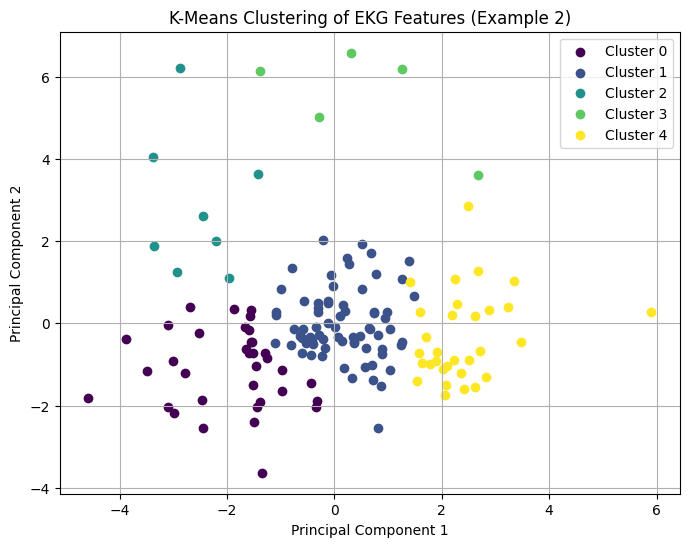

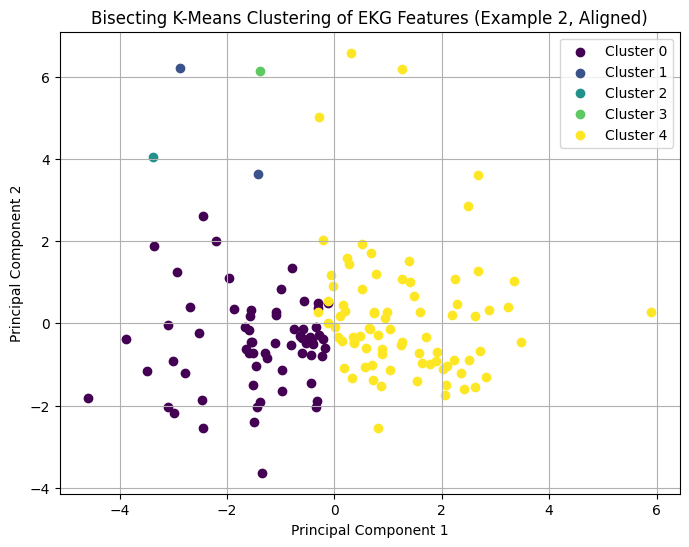

In [37]:
def max_variance_bisecting_kmeans(X, k, random_state=167, n_init=10):
    """
    Implements the bisecting k-means algorithm.

    Args:
        X (np.array): The data to cluster.
        k (int): The desired number of clusters.
        random_state (int): Random seed for reproducibility.
        n_init (int): Number of times k-means will be run with different centroid seeds.

    Returns:
        np.array: Cluster labels for each data point.
    """
    # Start with one cluster containing all data points
    clusters = [X]
    
    while len(clusters) < k:
        # Find cluster with max SSE or size or variance
        # Here, we use SSE as the criterion

        # extract the chosen cluster
        index_to_split = np.argmax([np.var(cluster, axis=0).mean() for cluster in clusters])
        cluster_to_split = clusters.pop(index_to_split)
        
        # Perform k-means on the chosen cluster with k=2 in order to split it into two subclusters
        kmeans_split = KMeans(n_clusters=2, random_state=random_state, n_init=n_init)
        split_labels = kmeans_split.fit_predict(cluster_to_split)
        
        # Extend the clusters list with the two new clusters
        cluster1 = cluster_to_split[split_labels == 0]
        cluster2 = cluster_to_split[split_labels == 1]
        clusters.extend([cluster1, cluster2])
        
    # Assign final labels to each sample in the original data
    final_labels = np.zeros(len(X), dtype=int)
    for i, cluster in enumerate(clusters):
        for row in cluster:
            index = np.where((X == row).all(axis=1))[0][0]
            final_labels[index] = i
    return final_labels

# Align the cluster labels of bisecting k-means with k-means
cluster_labels_max_variance_bisecting_kmeans_ex2 = max_variance_bisecting_kmeans(X_scaled_ex2, k=5, random_state=random_state)
print("\nBisecting K-Means Cluster Labels (using Example 2 features):\n", cluster_labels_max_variance_bisecting_kmeans_ex2)
aligned_labels_max_variance = align_cluster_labels(X_reduced_ex2, cluster_labels_kmeans_ex2, cluster_labels_max_variance_bisecting_kmeans_ex2)
visualize_clustering_2d(X_reduced_ex2, cluster_labels_kmeans_ex2, 'K-Means Clustering of EKG Features (Example 2)')
visualize_clustering_2d(X_reduced_ex2, aligned_labels_max_variance, 'Bisecting K-Means Clustering of EKG Features (Example 2, Aligned)')

**Observations**

The clusterings for bisection based on max variance are highly different than both the original k-means clustering and bisection using max size and bisection using max SSE. For max variance, clusters 0 and 4 are both by far the largest, while clusters 1, 2, and 3 all contian only one or 2 data points each. In contrast, the normal k-means and bisection using max size and max SSE all have cluster 0, cluster 1, and cluster 4 as roughly equal and the largest clusters, while clusters 2 and 3 are somewhat smaller (although not as small as in the max variance version). This makes sense, as very small, disperse groups of points (which might possibly be noise points) likely have large variance, making them much more likely to get even further split by bisection than more dense groups, leading to one or two clusters being very large and somewhat dispersed with several other clusters being very small (just 1 or 2 points) and being far away from other points.